# Reed Solomon Code

Implementation of the Reed Solomon quantum code

R 0 1 2 3 4 5 6 7 8 9 10
X_ERROR(0.1) 0 1 2 3 4 5 6
CX 0 7 1 7 2 7 3 7
M 7
DETECTOR rec[-1]
MX 0 1 2 3 4 5 6
OBSERVABLE_INCLUDE(0) rec[-1]
CX 1 8 2 8 3 8 4 8
M 8
DETECTOR rec[-1]
MX 0 1 2 3 4 5 6
OBSERVABLE_INCLUDE(0) rec[-1]
CX 2 9 3 9 4 9 5 9
M 9
DETECTOR rec[-1]
MX 0 1 2 3 4 5 6
OBSERVABLE_INCLUDE(0) rec[-1]
CX 3 10 4 10 5 10 6 10
M 10
DETECTOR rec[-1]
MX 0 1 2 3 4 5 6
OBSERVABLE_INCLUDE(0) rec[-1]


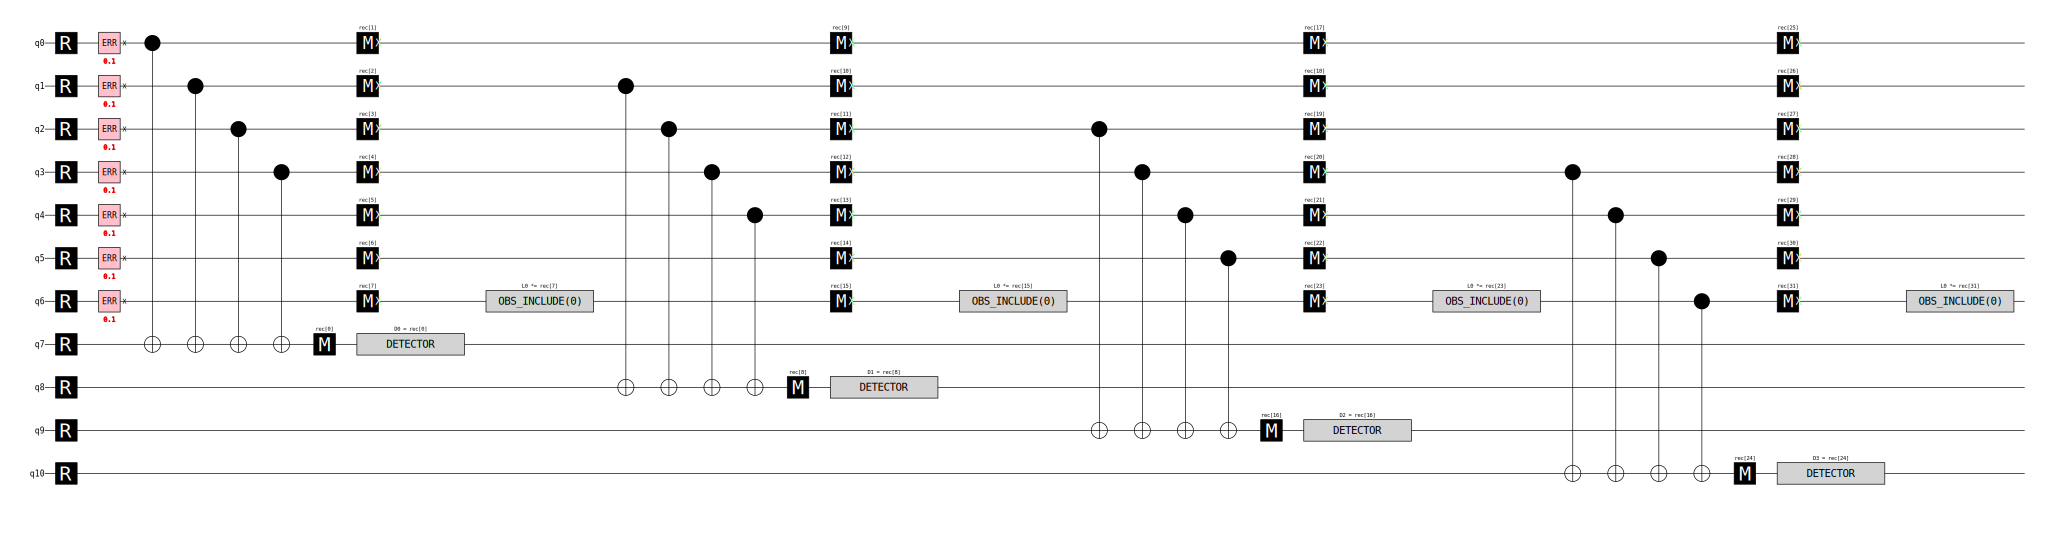

In [6]:
import stim

'''
Building the circuit for the asymmetric RS[7,3,5] code. A logical
X observable is defined from final X-basis measurements.
'''

def rs_circuit(p=0.0):
    c = stim.Circuit()

    data = list(range(7))
    anc  = list(range(7, 11))

    c.append("R", data + anc)

    # X noise
    if p > 0:
        c.append("X_ERROR", data, p)

    # Z stabilizers
    stabilizers = [
        [0, 1, 2, 3],  # S0
        [1, 2, 3, 4],  # S1
        [2, 3, 4, 5],  # S2
        [3, 4, 5, 6],  # S3
    ]

    # measure stabilizers 
    for s, a in zip(stabilizers, anc):
        for q in s:
            c.append("CX", [q, a])  
        c.append("M", [a])       

        c.append("DETECTOR", [stim.target_rec(-1)])

        for q in data:
            c.append("MX", [q])
        c.append("OBSERVABLE_INCLUDE", [stim.target_rec(-1)], 0)

    return c

c = rs_circuit(p=0.1)
print(c)

c.diagram('timeline-svg')

## Compute Reed Solomon Syndromes

In [3]:
from itertools import combinations

'''
Implement a decoder for the RS[7,3,5] code that can correct up to 2 X errors.

'''

stabilizers = [
    [0, 1, 2, 3],  # S0
    [1, 2, 3, 4],  # S1
    [2, 3, 4, 5],  # S2
    [3, 4, 5, 6]   # S3
]

def compute_syndrome(error_qubits):
    """
    Compute 4-bit syndrome for a given set of X errors
    """
    syndrome = []
    for stab in stabilizers:
        parity = sum([1 for q in error_qubits if q in stab]) % 2
        syndrome.append(parity)
    return tuple(syndrome)  # use tuple as dict key

# looking up syndrome to error patterns
syndrome_table = {}

# single-X errors
for q in range(7):
    synd = compute_syndrome([q])
    syndrome_table[synd] = [q]

# double-X errors
for q1, q2 in combinations(range(7), 2):
    synd = compute_syndrome([q1, q2])
    syndrome_table[synd] = [q1, q2]

def decode_syndrome(syndrome_bits):
    """
    Decode syndrome to correction qubits
    """
    syndrome = tuple(syndrome_bits)
    return syndrome_table.get(syndrome, [])

# sanity checking
print("Single-X error syndromes:")
for q in range(7):
    print(f"Error on {q}: syndrome = {compute_syndrome([q])}")
print("")

Single-X error syndromes:
Error on 0: syndrome = (1, 0, 0, 0)
Error on 1: syndrome = (1, 1, 0, 0)
Error on 2: syndrome = (1, 1, 1, 0)
Error on 3: syndrome = (1, 1, 1, 1)
Error on 4: syndrome = (0, 1, 1, 1)
Error on 5: syndrome = (0, 0, 1, 1)
Error on 6: syndrome = (0, 0, 0, 1)



## Compute Reed Solomon Logical Rate

 Our simulated logical error rate is around 0.088, and the theoretical has error rate is 0.02

In [7]:
import numpy as np

def logical_error_rate(p=0.1, num_shots=100000):
    c = rs_circuit(p)
    sampler = c.compile_sampler()

    logical_errors = 0

    for _ in range(num_shots):
        # sample measurement outcomes
        sample = sampler.sample(shots=1)[0]
        
        # 1st 4 measurements are stabilizers
        syndrome_bits = sample[:4]
        
        # decode to get suggested X corrections
        correction_qubits = decode_syndrome(syndrome_bits)
        
        # logical qubit = qubit 0
        # assume initial logical state
        logical_flipped = 0
        if 0 in correction_qubits:
            logical_flipped ^= 1

        if logical_flipped != 0:
            logical_errors += 1

    rate = logical_errors / num_shots
    print(f"Simulated logical error rate at p={p}: {rate}")
    return rate

if __name__ == "__main__":
    logical_error_rate(p=0.1, num_shots=100000)

Simulated logical error rate at p=0.1: 0.08823
